### CNN Convolution Task

In [1]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

def get_preprocessed_data(images, targets):
    images = np.array(images / 255.0, dtype=np.float32)
    targets = np.array(targets, dtype=np.float32)
    
    return images, targets

def get_preprocessed_ohe(images, targets):
    images, targets = get_preprocessed_data(images, targets)
    oh_targets = to_categorical(targets)
    return images, oh_targets

def get_train_valid_test(train_images, train_targets, test_images, test_targets, validation_size=0.2, random_state=124):
    train_images, train_oh_targets = get_preprocessed_ohe(train_images, train_targets)
    test_images, test_oh_targets = get_preprocessed_ohe(test_images, test_targets)
    
    train_train_images, validation_images, train_train_oh_targets, validation_oh_targets = \
    train_test_split(train_images, train_oh_targets, stratify=train_oh_targets, test_size=validation_size, random_state=random_state)
    
    return (train_train_images, train_train_oh_targets), (validation_images, validation_oh_targets), (test_images, test_oh_targets)

In [2]:
from tensorflow.keras.datasets import mnist

(train_images, train_targets), (test_images, test_targets) = mnist.load_data()

(train_train_images, train_train_oh_targets), (validation_images, validation_oh_targets), (test_images, test_oh_targets) = \
get_train_valid_test(train_images, train_targets, test_images, test_targets)

print(train_train_images.shape, train_train_oh_targets.shape)
print(validation_images.shape, validation_oh_targets.shape)
print(test_images.shape, test_oh_targets.shape)

(48000, 28, 28) (48000, 10)
(12000, 28, 28) (12000, 10)
(10000, 28, 28) (10000, 10)


In [3]:
import matplotlib.pyplot as plt

class_names = ['0','1','2','3','4','5','6','7','8','9']

def show_images(images, targets, ncols=8):
    figure, axs = plt.subplots(figsize=(22, 6), nrows=1, ncols=ncols)
    for i in range(ncols):
        axs[i].imshow(images[i], cmap='gray')
        axs[i].set_title(class_names[targets[i]])

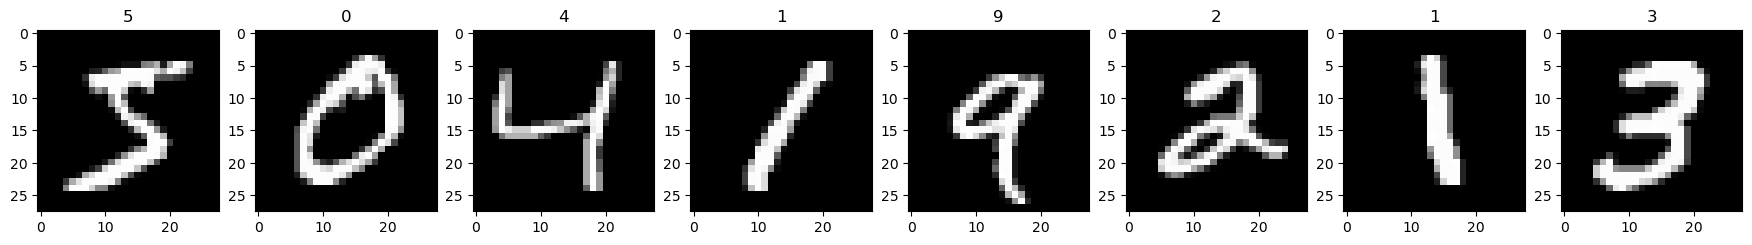

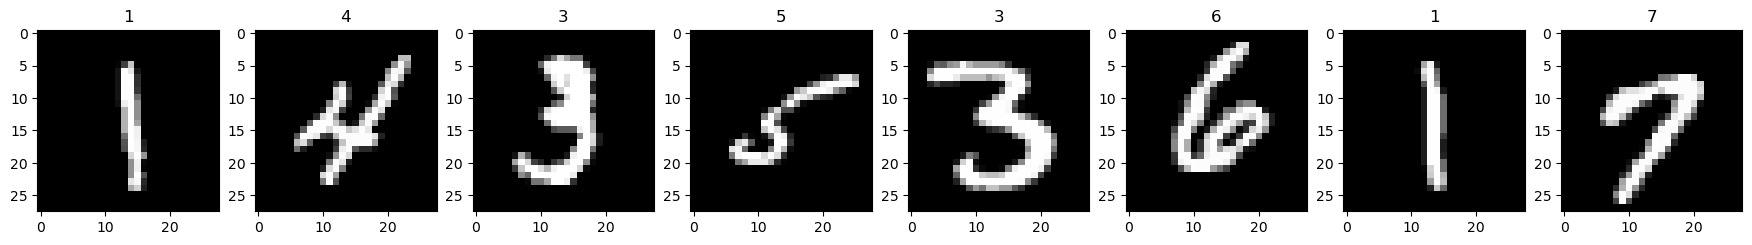

In [4]:
show_images(train_images[:8], train_targets[:8])
show_images(train_images[8:16], train_targets[8:16])

In [9]:
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model

INPUT_SIZE = 28

input_tensor = Input(shape=(INPUT_SIZE, INPUT_SIZE, 1))

x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(input_tensor)

x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)

x = MaxPooling2D(2)(x)

x = Flatten()(x)
x = Dropout(rate=0.5)(x)
x = Dense(50, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 26, 26, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 10816)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10816)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │         540,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             510 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 560,176 (2.14 MB)

 Trainable params: 560,176 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

model.compile(optimizer=Adam(0.001), loss=CategoricalCrossentropy(), metrics=['acc'])

In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

mcp_cb = ModelCheckpoint(
    filepath="./callback_files/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
    monitor='val_loss',
    # 모든 epoch의 파일을 저장하지 않고 좋은 성능이라 판단될 경우만 저장할 때 True설정
    save_best_only=False,
    save_weights_only=True,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min'
)

history = model.fit(x=train_train_images, y=train_train_oh_targets, validation_data=(validation_images, validation_oh_targets), batch_size=64, epochs=20, callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - acc: 0.8839 - loss: 0.3819 - val_acc: 0.9771 - val_loss: 0.0743 - learning_rate: 0.0010
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - acc: 0.9782 - loss: 0.0705 - val_acc: 0.9832 - val_loss: 0.0549 - learning_rate: 0.0010
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - acc: 0.9850 - loss: 0.0469 - val_acc: 0.9858 - val_loss: 0.0452 - learning_rate: 0.0010
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - acc: 0.9868 - loss: 0.0404 - val_acc: 0.9893 - val_loss: 0.0389 - learning_rate: 0.0010
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - acc: 0.9887 - loss: 0.0347 - val_acc: 0.9871 - val_loss: 0.0418 - learning_rate: 0.0010
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - acc: 0.9920 - loss: 0.0244 - val_acc: 0.9868 - val_loss: 0.0462 - learning_rate: 0.0010
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - acc: 0.9940 - loss: 0.0187 - val_acc: 0.9910 - val_loss: 0.0340 - learning_rate: 1.0000e-04
Ep

In [15]:
model.evaluate(test_images, test_oh_targets, batch_size=64, verbose=1)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9881 - loss: 0.0389


[0.029486550018191338, 0.9914000034332275]

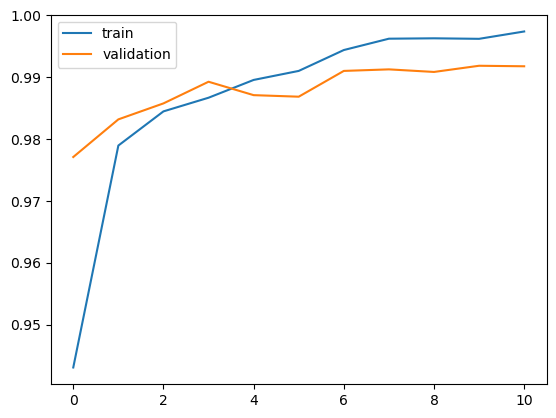

In [16]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.legend()
    
show_history(history)